In the name of Allah

### Import libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

### preprocessing data

In [4]:
!cp /content/drive/MyDrive/MLSD/hw1/data/feature_eng/ex4_autoencoder_data.csv /content/

In [5]:
df = pd.read_csv("/content/ex4_autoencoder_data.csv")
df

,cat1,cat2,cat3,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,electronic-devices,computers,laptop-notebook-macbook,0.089151,0.008438,0.022490,0.097807,-0.067019,0.016574,0.059873,-0.003597,-0.019109,-0.074389,0.087049,-0.078942,-0.006335,-0.031975,-0.033369,0.069154
1,electronic-devices,computers,laptop-notebook-macbook,0.048605,0.061103,0.048759,0.080163,-0.064289,-0.005208,0.026603,0.001288,-0.018102,-0.082288,0.085979,-0.076402,-0.019637,-0.035297,-0.045136,0.110879
2,electronic-devices,computers,laptop-notebook-macbook,0.162398,-0.031428,-0.001551,0.121659,-0.066044,0.058413,0.123528,-0.011016,-0.026502,-0.083494,0.075049,-0.078492,0.015707,-0.031163,-0.030246,0.028926
3,electronic-devices,computers,laptop-notebook-macbook,-0.005929,0.141440,0.091159,0.054182,-0.052086,-0.027547,-0.011627,0.013037,-0.025825,-0.093566,0.082300,-0.067685,-0.040264,-0.053295,-0.072474,0.184169
4,electronic-devices,computers,laptop-notebook-macbook,0.275427,-0.074632,-0.021813,0.159823,-0.064344,0.123022,0.223682,-0.024841,-0.044335,-0.105894,0.043175,-0.085189,0.047519,-0.038922,-0.034127,-0.023200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,vehicles,auto,car,-1.699697,2.948127,2.713972,-0.840179,0.362119,-0.948378,-1.246765,0.403115,-0.643546,-0.469890,-0.353131,0.168936,-0.462169,-0.588958,-0.885949,3.071827
2296,vehicles,auto,car,-1.521031,2.650091,2.433774,-0.743897,0.317530,-0.850172,-1.117113,0.362310,-0.576655,-0.429391,-0.307108,0.144132,-0.417919,-0.533010,-0.799032,2.764719
2297,vehicles,motorcycles,Unknown,-1.587309,2.760477,2.536331,-0.778848,0.334466,-0.886266,-1.166287,0.377575,-0.600134,-0.443495,-0.323480,0.153553,-0.433576,-0.553423,-0.831913,2.876469
2298,vehicles,auto,car,-1.753141,3.037262,2.796290,-0.868397,0.375771,-0.977534,-1.286897,0.415730,-0.662401,-0.481053,-0.366235,0.176554,-0.474648,-0.605348,-0.912605,3.161704


In [6]:
X_df = df[[f'{i}' for i in range(16)]]
X_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.089151,0.008438,0.022490,0.097807,-0.067019,0.016574,0.059873,-0.003597,-0.019109,-0.074389,0.087049,-0.078942,-0.006335,-0.031975,-0.033369,0.069154
1,0.048605,0.061103,0.048759,0.080163,-0.064289,-0.005208,0.026603,0.001288,-0.018102,-0.082288,0.085979,-0.076402,-0.019637,-0.035297,-0.045136,0.110879
2,0.162398,-0.031428,-0.001551,0.121659,-0.066044,0.058413,0.123528,-0.011016,-0.026502,-0.083494,0.075049,-0.078492,0.015707,-0.031163,-0.030246,0.028926
3,-0.005929,0.141440,0.091159,0.054182,-0.052086,-0.027547,-0.011627,0.013037,-0.025825,-0.093566,0.082300,-0.067685,-0.040264,-0.053295,-0.072474,0.184169
4,0.275427,-0.074632,-0.021813,0.159823,-0.064344,0.123022,0.223682,-0.024841,-0.044335,-0.105894,0.043175,-0.085189,0.047519,-0.038922,-0.034127,-0.023200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2295,-1.699697,2.948127,2.713972,-0.840179,0.362119,-0.948378,-1.246765,0.403115,-0.643546,-0.469890,-0.353131,0.168936,-0.462169,-0.588958,-0.885949,3.071827
2296,-1.521031,2.650091,2.433774,-0.743897,0.317530,-0.850172,-1.117113,0.362310,-0.576655,-0.429391,-0.307108,0.144132,-0.417919,-0.533010,-0.799032,2.764719
2297,-1.587309,2.760477,2.536331,-0.778848,0.334466,-0.886266,-1.166287,0.377575,-0.600134,-0.443495,-0.323480,0.153553,-0.433576,-0.553423,-0.831913,2.876469
2298,-1.753141,3.037262,2.796290,-0.868397,0.375771,-0.977534,-1.286897,0.415730,-0.662401,-0.481053,-0.366235,0.176554,-0.474648,-0.605348,-0.912605,3.161704


In [7]:
y_df = {}
cat1_2_id = {t:i for i, t in enumerate(list(np.unique(df['cat1'])))}
cat2_2_id = {t:i for i, t in enumerate(list(np.unique(df['cat2'])))}
cat3_2_id = {t:i for i, t in enumerate(list(np.unique(df['cat3'])))}
y_df['cat1'] = [cat1_2_id[t] for t in df['cat1']]
y_df['cat2'] = [cat2_2_id[t] for t in df['cat2']]
y_df['cat3'] = [cat3_2_id[t] for t in df['cat3']]
y_df = pd.DataFrame(y_df)
y_df

,cat1,cat2,cat3
0,0,4,6
1,0,4,6
2,0,4,6
3,0,4,6
4,0,4,6
...,...,...,...
2295,3,1,5
2296,3,1,5
2297,3,6,0
2298,3,1,5


### Split train, val, test

In [8]:
X = {'train': None, 'test': None, 'val': None}
y = {'train': None, 'test': None, 'val': None}

X_trainval, X['test'], y_trainval, y['test'] = train_test_split(X_df, y_df, 
                                                                test_size=0.2, 
                                                                stratify=y_df, 
                                                                shuffle=True, 
                                                                random_state=69)

X['train'], X['val'], y['train'], y['val'] = train_test_split(X_trainval, 
                                                              y_trainval,
                                                              test_size=0.1, 
                                                              stratify=y_trainval, 
                                                              shuffle=True, 
                                                              random_state=21)



scaler = MinMaxScaler()
X['train'] = scaler.fit_transform(X['train'])
X['val'] = scaler.transform(X['val'])
X['test'] = scaler.transform(X['test'])
X['train'], y['train'] = np.array(X['train']).astype('float32'), np.array(y['train'])
X['val'], y['val'] = np.array(X['val']).astype('float32'), np.array(y['val'])
X['test'], y['test'] = np.array(X['test']).astype('float32'), np.array(y['test'])

### Create dataset and dataloaders

In [9]:
class Data(Dataset):
    def __init__(self, x_train, y_train):
        self.x = x_train
        self.y = y_train
        self.len = self.x.shape[0]

    def __getitem__(self,index):      
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

Set hyper-parameter:

- batch-size: 256
- weighted-loss: True

In [10]:
batch_size = 256
weighted_loss = False
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataloaders = {}
dataset_sizes = {}

for phase in ['train', 'val', 'test']:
    data_set = Data(X[phase], y[phase])
    dataset_sizes[phase] = data_set.len
    dataloaders[phase] = DataLoader(dataset=data_set, batch_size=batch_size)

### Define Model

In [11]:
class MyClassifier(nn.Module):
    def __init__(self, in_dim, out1_dim, out2_dim, out3_dim):
        super(MyClassifier, self).__init__()
        self.in_layer = nn.Linear(in_dim, 128)
        self.bn0 = nn.BatchNorm1d(128)
        self.hidden1_layer = nn.Linear(128, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.hidden2_layer = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.out1_layer = nn.Linear(32, out1_dim)
        self.out2_layer = nn.Linear(32+out1_dim, out2_dim)
        self.out3_layer = nn.Linear(32+out1_dim+out2_dim, out3_dim)
        self.soft_max = nn.Softmax(dim=1)
    

    def forward(self,x):
        x = self.in_layer(x)
        x = self.bn0(x)
        x = torch.relu(x)

        x = self.hidden1_layer(x)
        x = self.bn1(x)
        x = torch.relu(x)

        x = self.hidden2_layer(x)
        x = self.bn2(x)
        x = torch.relu(x)

        out1 = self.out1_layer(x)

        out2 = torch.cat([x, out1], dim=1)
        out2 = self.out2_layer(out2)

        out3 = torch.cat([x, out1, out2], dim=1)
        out3 = self.out3_layer(out3)

        out1 = self.soft_max(out1)
        out2 = self.soft_max(out2)
        out3 = self.soft_max(out3)

        return out1, out2, out3

### Define Loss

In [12]:
criterion = [None, None, None]

if weighted_loss:
    class_weights = [None]*3
    for i in range(3):
        class_weights[i] = compute_class_weight(class_weight = "balanced", 
                                                classes = np.unique(np.array(y['train'])[:,i]), 
                                                y = np.array(y['train'])[:,i])
        class_weights[i] = torch.tensor(class_weights[i], dtype=torch.float)
        criterion[i] = nn.CrossEntropyLoss(weight=class_weights[i])
else:
    criterion[0] = nn.CrossEntropyLoss()
    criterion[1] = nn.CrossEntropyLoss()
    criterion[2] = nn.CrossEntropyLoss()

### Load model and set optimizer to Adam

Set hyper-parameter:

- a, b, c: 1, 2, 5 (Cost function coefficients for different categories)

In [17]:
model = MyClassifier(in_dim=X['train'].shape[1], 
                     out1_dim=len(np.unique(y_df['cat1'])), 
                     out2_dim=len(np.unique(y_df['cat2'])), 
                     out3_dim=len(np.unique(y_df['cat3']))
                     )

model = model.to(device)

learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

a = 1
b = 2
c = 5

### Define train function

In [18]:
def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = [100, 100, 100]
    loss_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = [0,0,0]

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = [None, None, None]
                    for i in range(3):
                        loss[i] = criterion[i](outputs[i], labels[:,i])
                        running_loss[i] += loss[i].item()
                    total_loss = a*loss[0] + b*loss[1] + c*loss[2]

                    if phase == 'train':
                        total_loss.backward()
                        optimizer.step()

            for i in range(3):
                running_loss[i] = running_loss[i]/dataset_sizes[phase]
                print(f'{phase} Loss[cat{i}]: {running_loss[i]:.6f}')
            
            loss_history[phase].append(running_loss)

            # deep copy the model
            diff = 1e-5
            if phase == 'val' and (running_loss[0]+diff < best_loss[0] or running_loss[1]+diff < best_loss[1] or running_loss[2]+diff < best_loss[2]):
                best_loss = running_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print('** Model Saved **')

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_history

### Train model

In [19]:
model, loss_history = train_model(model, criterion, optimizer, num_epochs=4000)

Streaming output truncated to the last 5000 lines.
train Loss[cat1]: 0.007054
train Loss[cat2]: 0.008781
val Loss[cat0]: 0.006545
val Loss[cat1]: 0.009425
val Loss[cat2]: 0.011705

Epoch 3450/4000
----------
train Loss[cat0]: 0.004823
train Loss[cat1]: 0.007053
train Loss[cat2]: 0.008778
val Loss[cat0]: 0.006471
val Loss[cat1]: 0.009380
val Loss[cat2]: 0.011638

Epoch 3451/4000
----------
train Loss[cat0]: 0.004824
train Loss[cat1]: 0.007054
train Loss[cat2]: 0.008777
val Loss[cat0]: 0.006422
val Loss[cat1]: 0.009352
val Loss[cat2]: 0.011614

Epoch 3452/4000
----------
train Loss[cat0]: 0.004825
train Loss[cat1]: 0.007057
train Loss[cat2]: 0.008781
val Loss[cat0]: 0.006439
val Loss[cat1]: 0.009362
val Loss[cat2]: 0.011624

Epoch 3453/4000
----------
train Loss[cat0]: 0.004827
train Loss[cat1]: 0.007060
train Loss[cat2]: 0.008786
val Loss[cat0]: 0.006516
val Loss[cat1]: 0.009404
val Loss[cat2]: 0.011672

Epoch 3454/4000
----------
train Loss[cat0]: 0.004824
train Loss[cat1]: 0.007058
tr

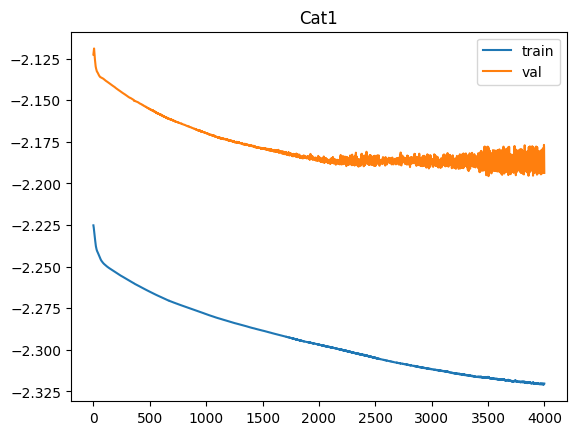

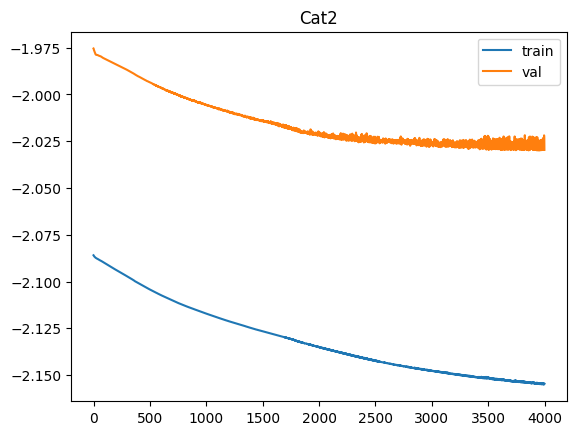

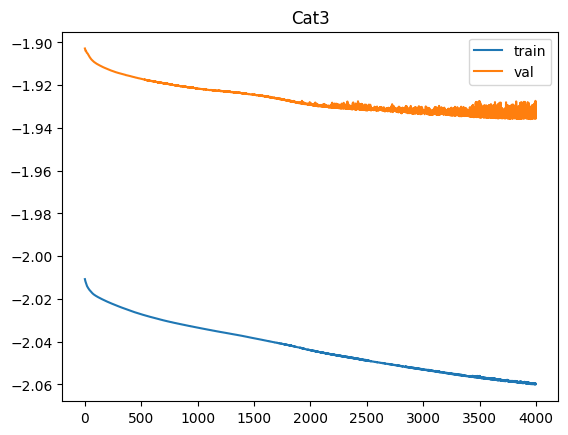

In [20]:
def plot_loss_history(title, index, loss_history):
    loss_cat_train = [l[index] for l in np.log10(loss_history['train'])]
    loss_cat_val = [l[index] for l in np.log10(loss_history['val'])]
    plt.plot(loss_cat_train, label="train")
    plt.plot(loss_cat_val, label="val")
    plt.title(title)
    plt.legend()
    plt.show()

plot_loss_history("Cat1", 0, loss_history)
plot_loss_history("Cat2", 1, loss_history)
plot_loss_history("Cat3", 2, loss_history)

### Testing the model

In [21]:
model.eval()

MyClassifier(
  (in_layer): Linear(in_features=16, out_features=128, bias=True)
  (bn0): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden1_layer): Linear(in_features=128, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (hidden2_layer): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out1_layer): Linear(in_features=32, out_features=4, bias=True)
  (out2_layer): Linear(in_features=36, out_features=7, bias=True)
  (out3_layer): Linear(in_features=43, out_features=10, bias=True)
  (soft_max): Softmax(dim=1)
)

#### Calculate Loss

In [22]:
test_loss = [0,0,0]
for inputs, labels in dataloaders['test']:
    with torch.no_grad():
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = [None, None, None]
        for i in range(3):
            loss[i] = criterion[i](outputs[i], labels[:,i])
            test_loss[i] += loss[i].item()
for i in range(3):
    test_loss[i] = test_loss[i]/dataset_sizes['test']
for i in range(3):
    print(f'Test Loss[cat{i}]: {test_loss[i]:.6f}')

Test Loss[cat0]: 0.005046
Test Loss[cat1]: 0.007382
Test Loss[cat2]: 0.009295


#### Define a function to use the model directly

In [23]:
def get_cat(x):
    model.eval()
    with torch.no_grad():
        x = x.to(device)
        p1, p2, p3 = model(x)
        _, out1 = torch.max(p1, dim = 1)
        _, out2 = torch.max(p2, dim = 1)
        _, out3 = torch.max(p3, dim = 1)
    return out1, out2, out3

#### Calculate Accuracy

In [24]:
y_true = []
y_pred = []
for inputs, labels in dataloaders['test']:
    outputs = get_cat(inputs)
    outputs = [outputs[0].cpu().detach().numpy(), 
               outputs[1].cpu().detach().numpy(), 
               outputs[2].cpu().detach().numpy()]
    outputs = [[o1, o2, o3] for o1, o2, o3 in zip(outputs[0], outputs[1], outputs[2])]
    y_true.extend(labels.cpu().detach().numpy())
    y_pred.extend(outputs)

In [25]:
def accuracy(pred, true):
    true_count = [0,0,0]
    for p,t in zip(pred, true):
        for i in range(3):
            if p[i] == t[i]:
                true_count[i] += 1
    true_count = np.divide(true_count,len(pred))
    return true_count

In [26]:
acc = accuracy(pred=y_pred, true=y_true)
for i in range(3):
    print(f'Accuracy [cat{i+1}]: %{acc[i]*100:.2f}')

Accuracy [cat1]: %56.74
Accuracy [cat2]: %46.52
Accuracy [cat3]: %32.83


#### Some sample

In [27]:
for inputs, labels in dataloaders['test']:
    outputs = get_cat(inputs)
    break

outputs = [outputs[0].cpu().detach().numpy(),
           outputs[1].cpu().detach().numpy(),
           outputs[2].cpu().detach().numpy()]
outputs = [[o1, o2, o3] for o1, o2, o3 in zip(outputs[0], outputs[1], outputs[2])]
labels = labels.cpu().detach().numpy() 
for output, label in zip(outputs, labels):
    for i in range(3):
        print(f'[cat{i+1}] True: {label[i]} \t Pred: {output[i]} \t Eq: {output[i] == label[i]}')

[cat1] True: 0 	 Pred: 1 	 Eq: False
[cat2] True: 4 	 Pred: 0 	 Eq: False
[cat3] True: 6 	 Pred: 9 	 Eq: False
[cat1] True: 0 	 Pred: 1 	 Eq: False
[cat2] True: 5 	 Pred: 0 	 Eq: False
[cat3] True: 7 	 Pred: 7 	 Eq: True
[cat1] True: 0 	 Pred: 1 	 Eq: False
[cat2] True: 5 	 Pred: 0 	 Eq: False
[cat3] True: 7 	 Pred: 9 	 Eq: False
[cat1] True: 0 	 Pred: 3 	 Eq: False
[cat2] True: 5 	 Pred: 1 	 Eq: False
[cat3] True: 7 	 Pred: 5 	 Eq: False
[cat1] True: 3 	 Pred: 3 	 Eq: True
[cat2] True: 1 	 Pred: 1 	 Eq: True
[cat3] True: 5 	 Pred: 5 	 Eq: True
[cat1] True: 2 	 Pred: 2 	 Eq: True
[cat2] True: 3 	 Pred: 3 	 Eq: True
[cat3] True: 1 	 Pred: 1 	 Eq: True
[cat1] True: 0 	 Pred: 2 	 Eq: False
[cat2] True: 4 	 Pred: 3 	 Eq: False
[cat3] True: 6 	 Pred: 6 	 Eq: True
[cat1] True: 2 	 Pred: 1 	 Eq: False
[cat2] True: 3 	 Pred: 0 	 Eq: False
[cat3] True: 3 	 Pred: 9 	 Eq: False
[cat1] True: 1 	 Pred: 1 	 Eq: True
[cat2] True: 0 	 Pred: 0 	 Eq: True
[cat3] True: 9 	 Pred: 8 	 Eq: False
[cat1] True